<a href="https://colab.research.google.com/github/tolom131/Human-Activity-Recognition/blob/main/supervised%20autoencoder_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Conv1D, Activation, MaxPooling1D, UpSampling1D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

import random
from resource import *
import time
import math
import sys
from collections import Counter

import random as rn
from tensorflow.keras import backend as K

In [ ]:
class Dataset:
    def __init__(self, file_path):
        self.file_path = file_path
        
    def read_data(self):
        column_names = ['user-id',  # 1
                        'activity', # 2
                        'timestamp',# 3
                        'x-axis',   # 4
                        'y-axis',   # 5
                        'z-axis']   # 6

        df = pd.read_csv(self.file_path,
                         header=None,
                         names=column_names)
    
        df['z-axis'].replace(regex=True,
                             inplace=True,
                             to_replace=r';',
                             value=r'')
        df['z-axis'] = df['z-axis'].apply(self.convert_to_float)

        df.dropna(axis=0, how='any', inplace=True)
        LABEL = 'ActivityEncoded'
        
        # abelEncoder를 통해 레이블의 문자열을 정수로 변환)
        le = preprocessing.LabelEncoder()
        df[LABEL] = le.fit_transform(df['activity'].values.ravel())
        
        print("결측값 확인")
        print(df.isnull().sum())
        print()

        num_classes = le.classes_.size
        # ver1.2 추가
        # Acitivity encoded number: Downstairs: 0. Jogging: 1. Sitting: 2. Standing: 3. Upstairs: 4. Walking: 5. 
        print("Acitivity encoded number: ", end='')
        for idx, activity in enumerate(le.classes_):
            print(activity, ": ", idx, ".", sep='', end=' ')
        print()
        
        return df, num_classes
    
    def convert_to_float(self, x):
        try:
            return np.float(x)
        except:
            return np.nan
        
    def show_basic_dataframe_info(self, dataframe):
        print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
        print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

    def create_segments_and_labels(self, df, label_name, num_classes):
        global TIME_PERIODS
        global STEP
        
        segments = []
        labels = []
        id_user = []
        
        # 메인 셀에서 만든 타입 스텝 길이와 스텝 길이를 입력받았다.
        # 이 변수들을 전역 처리하여 메소드 내에서도 처리할 수 있도록 한다.
        # 안해도 될 것 같은데 위치가 반대라서 전역 처리하였음.
        time_steps = TIME_PERIODS
        step = STEP
        
        # 1.2에서 추가
        # label_legnth: 각 activity에 해당하는 "batch"의 크기를 기록한다.
        # WISDM dataset의 경우 label마다 그 편차가 매우 심한데, 이를 처리하지 않고 입력함수를 만들면
        # 표본이 적은 label에 해당하는 입력 값들이 제대로 활성화 되지 않을 것이다.
        # 이를 해결하기 위하여 가장 낮은 값을 기준으로 각 레이블의 batch를 골고루 받는다.
        label_length = dict()
        
        # segment는 이중 리스트인데, segment = [x축 가속도, y축 가속도, z축 가속도, 해당하는 레이블(activity), id_user]가 타입 스텝만큼 저장되어 있다.
        # label_data는 이러한 이중 리스트를 계속 추가하는데, Downstair은 0이므로 0번째 인덱스에 이중 리스트가 담긴다.
        # 그러면 각 label_data는 삼중 리스트로 (batch_size, TIME_STEP, 5)만큼 저장되어 있을 것이다.
        label_data = [[] for _ in range(num_classes)]
        
        if step != time_steps:
            print("occuring overlapping!")
            
        for i in range(0, len(df) - time_steps, step):
            xs = df['x-axis'].values[i: i + time_steps]
            ys = df['y-axis'].values[i: i + time_steps]
            zs = df['z-axis'].values[i: i + time_steps]

            label = stats.mode(df[label_name][i: i + time_steps])
            user = stats.mode(df['user-id'][i: i + time_steps])

            if(len(df[label_name][i: i + time_steps]) == label[1][0]):
                # label[0][0]은 숫자다.반면 xs, ys, zs는 행단위로 쌓아올린 1차원 데이터이므로 같이 쌓아주기 위해선 time_step의 길이만큼 label[0][0]을 늘려주어야 한다.
                # user도 마찬가지이다.
                extended_label = np.full((time_steps, 1), label[0][0])
                extended_user = np.full((time_steps, 1), user[0][0])
                segment = np.column_stack([xs, ys, zs, extended_label, extended_user])
                label_data[label[0][0]].append(segment)
        
                # label_data의 길이로도 해당하는 레이블에 대한 배치 크기를 알 수 있다.
                # 딕셔너리는 해싱이라 빠르니까 만들어서 계산을 용이하게 하였다.
                if label[0][0] not in label_length:
                    label_length[label[0][0]] = 1
                else:
                    label_length[label[0][0]] += 1
        
        # print("label_length : ", label_length)
        # print("length of label_data : ", len(label_data))
        # # label_legnth는 각 레이블의 배치 크기를 담고 있다. n개의 activity에 대해서 최소 배치 크기를 확인한다.
        # # ver_1.4 추가: 레이블 개수가 6개가 아닐 때에도 dataset 만들기가 가능해지도록 변경.
        # MIN_LABEL_LEN = sys.maxsize
        # for i in range(num_classes):
        #     if label_length[i] < MIN_LABEL_LEN:
        #         MIN_LABEL_LEN = label_length[i]

        # print("가장 적은 레이블의 개수 : ", MIN_LABEL_LEN, ", 각 activty에 대해서 {}개의만 추출하여 dataset를 구성합니다.".format(MIN_LABEL_LEN))
        
        # # label_data[i]를 ndarray로 바꾸어서 np.random.choice로 만든 인덱스를 바로 대입할 수 있도록 한다.
        # # 즉, np.array([1,2,3,4,5])[0,1] = np.array([1,2]) 같은 변환 방식을 쉽게 하기 위함.
        # for i in range(num_classes):
        #     label_data[i] =  np.array(label_data[i])
        #     random_idx = np.random.choice(len(label_data[i]), MIN_LABEL_LEN, replace=False)
        #     label_data[i] = np.array(label_data[i])[random_idx]
        
        # 본 구현에서는 모든 레이블에 대한 data를 합쳐서 하나의  dataset으로 만든다.
        # 3차원 데이터에 대해서, 큐브를 예시로 든다면 큐브를 하나 두고 그 밑에 새로운 큐브를 두는 방식으로 (MIN_LABEL*6, TIMESTEP, 5)로 만든다.
        extracted_label_data = label_data[0]
        for i in range(1, num_classes):
            extracted_label_data = np.concatenate((extracted_label_data, label_data[i]), axis=0)
        
        # 가속도 값, label 값, id_user값 추출
        segments = extracted_label_data[:, :, :3]
        extended_labels = extracted_label_data[:, :, 3]
        extended_id_user = extracted_label_data[:, :, 4]
        
        # 에러 방지용 print & 하나의 배치에 대해 하나의 레이블을 가져야 하는데, 현재는 하나의 타입스텝에 대해 레이블을 가지고 있다.
        # 따라서 2차원 데이터를 1차원 데이터로 압축해야 한다. 전체를 더하고 나누는 방법도 있다.(예, tf.reduce_mean(x, axis=1)) 
        # 하지만 이는 부동 소수점 오차 이슈의 가능성이 있기 때문에,for loop을 돌렸다.
        for label, user in zip(extended_labels, extended_id_user):
            if len(set(label)) != 1:
                print("한 타임스텝 내의 레이블에 다른게 포함됨")
                continue
                
            if len(set(user)) != 1:
                print("한 타임스텝 내의 user에 다른게 포함됨")
                continue
            
            labels.append(label[0])
            id_user.append(user[0])
        
        reshaped_segments = np.array(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
        labels = np.asarray(labels, dtype=np.int32)
        id_user = np.asarray(id_user, dtype=np.int32)

        return reshaped_segments, labels, id_user

In [ ]:
def create_dataset(filepath):
    global TIME_PERIODS
    global STEP
    dt = Dataset(filepath)
    df, num_classes = dt.read_data()
    
    LABELS = np.unique(df['activity']).tolist()
    LABEL = 'ActivityEncoded'
    
    dt.show_basic_dataframe_info(df)  
    df = df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
    
    print("TIME_PERIODS : ", TIME_PERIODS)
    print("STEP : ", STEP)
    x_data, y_data, id_data = dt.create_segments_and_labels(df, LABEL, num_classes)

    # for keras
    x_train = x_data.astype('float32')
    y_train = y_data.astype('float32')
    
    # -20 ~ 20의 값을 -1 ~ 1로 preprocessing
    x_train = x_train / 20
    
    # one-hot encoding
    y_train = to_categorical(y_train, num_classes)
    
    print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
    return x_train, y_train, num_classes

In [ ]:
# matplotlib 그려주는 함수
# 왼쪽에는 train acc, val_acc를 그리고, 오른쪽에는 train_loss, val_loss를 그린다.
def make_graph(history):
    %matplotlib inline
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111) 
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.plot(history.history["classified_accuracy"])
    ax1.plot(history.history["val_classified_accuracy"])

    
    ax1.legend(["accuracy", "val_accuracy"])
   

    ax2.plot(history.history["loss"])
    ax2.plot(history.history["val_loss"])
    ax2.legend(["loss", "val_loss"])

    # ax1.set_xlabel("epoch")
    # ax1.set_ylabel("accuracy")
    # ax2.set_ylabel("loss")
    # ax2.set_xlabel("epoch")


    # plt.setp(ax1, ylabel="accuracy")
    # plt.setp(ax2, ylabel="loss")
    # # ax1.ylabel("accuracy")
    # ax2.ylabel("loss")

    plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_supervised_autoencoder(x_train, y_train, x_val, y_val, alpha = 0.1):    
    #############################
    # setting methods
    #############################
    initializer = tf.keras.initializers.GlorotNormal()
    earlystop = EarlyStopping(patience=100, monitor='val_loss', mode='min')
    
    filepath = "SAE.h5"
    checkpoint = ModelCheckpoint(filepath, verbose = 0, mode="min", save_best_only=True, save_weights_only = True)
    callbacks_list = [checkpoint]
    
    def make_adam(rates = 0.0001):
        return keras.optimizers.Adam(learning_rate=rates)
    
    #############################
    # Autoencoder
    #############################
    inputs = Input(shape=(TIME_PERIODS, N_FEATURES))

    x = Conv1D(64, kernel_size=3, padding="same", kernel_initializer= initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(128, kernel_size=3, padding="same", kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    encoded = MaxPooling1D(2)(x)

    # x = Conv1D(128, kernel_size=3, padding="same", kernel_initializer=initializer)(x)
    # x = BatchNormalization()(x)
    # x = Activation("selu")(x)
    # encoded = MaxPooling1D(2)(x)

    # x = Conv1D(128, kernel_size=3, padding="same", kernel_initializer=initializer)(encoded)
    # x = BatchNormalization()(x)
    # x = Activation("selu")(x)
    # x = UpSampling1D(2)(x)

    x = Conv1D(128, kernel_size=3, padding="same", kernel_initializer= initializer)(encoded)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    x = UpSampling1D(2)(x)

    x = Conv1D(64, kernel_size=3, padding="same", kernel_initializer= initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("selu")(x)
    x = UpSampling1D(2)(x)

    decoded = Conv1D(3, kernel_size=3, activation="linear", padding="same", name="decoded", kernel_initializer= initializer)(x)
    encoder = Model(inputs, encoded)
    autoencoder = Model(inputs, decoded)
    
    #############################
    # Classifier
    #############################    
    adam = make_adam(0.0005)

    # 기본 16 32 
    _, dim0, dim1 = encoder.layers[-1].output_shape
    x = Conv1D(filters=64, kernel_size=3, input_shape=(dim0, dim1), kernel_initializer=initializer)(encoded)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv1D(filters=128, kernel_size=3, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = LSTM(128, kernel_initializer=initializer)(x)
    classified = Dense(num_classes, activation="softmax", name="classified", kernel_initializer=initializer)(x)
    
    #############################
    # Semi-Supervised Autoencoder
    #############################    
    print("\ntranining supervised autoencoder!")
    model = Model(inputs=[inputs], outputs=[classified, decoded])
    model.compile(optimizer=adam, loss=["categorical_crossentropy", "mse"], loss_weights=[alpha, 1-alpha], metrics=["accuracy"])
    history = model.fit([x_train], [y_train, x_train], validation_data = ([x_val], [y_val, x_val]), batch_size = 128, epochs=700, verbose=1, callbacks=callbacks_list)
    print("traning finished!")
    
    return history, model, filepath


Creating Dataset!!


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


결측값 확인
user-id            0
activity           0
timestamp          0
x-axis             0
y-axis             0
z-axis             0
ActivityEncoded    0
dtype: int64

Acitivity encoded number: Jogging: 0. LyingDown: 1. Sitting: 2. Stairs: 3. Standing: 4. Walking: 5. 
Number of columns in the dataframe: 7
Number of rows in the dataframe: 2980765

TIME_PERIODS :  200
STEP :  200
x_train.shape :  (14423, 200, 3) y_train.shape:  (14423, 6)

tranining supervised autoencoder!
Epoch 1/700
91/91 [==============================] - 9s 56ms/step - loss: 0.1810 - classified_loss: 0.7233 - decoded_loss: 0.1208 - classified_accuracy: 0.7367 - decoded_accuracy: 0.6573 - val_loss: 0.2275 - val_classified_loss: 1.7930 - val_decoded_loss: 0.0536 - val_classified_accuracy: 0.2982 - val_decoded_accuracy: 0.6696
Epoch 2/700
91/91 [==============================] - 4s 46ms/step - loss: 0.0841 - classified_loss: 0.5613 - decoded_loss: 0.0311 - classified_accuracy: 0.7832 - decoded_accuracy: 0.7422 - val_los

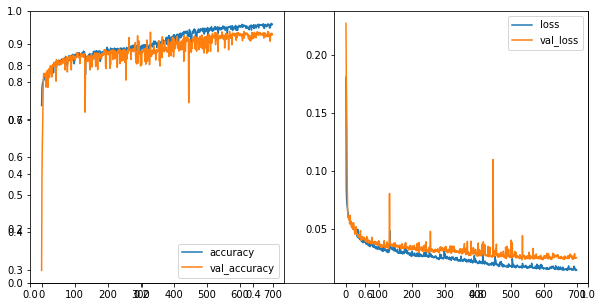

46/46 [==============================] - 0s 9ms/step - loss: 0.0289 - classified_loss: 0.2745 - decoded_loss: 0.0016 - classified_accuracy: 0.9293 - decoded_accuracy: 0.8141
test acc :  0.9293139576911926
test loss :  0.02892826870083809
f1 score :  0.9018701486582158
[[208   0   2   1   0   0]
 [  0 123  11   0   0   0]
 [  0  13 291   0  11   6]
 [  0   0   0  23   0   3]
 [  0   2  27   0  94  14]
 [  0   1   3   1   7 602]]


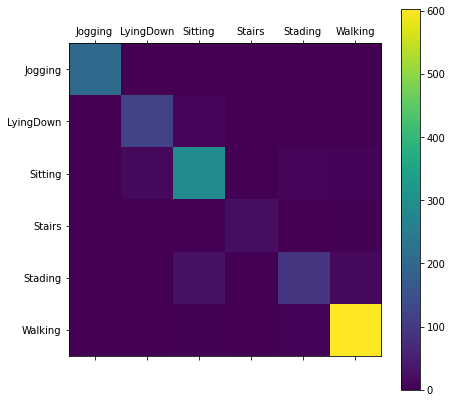

In [ ]:
# fix the random seed
# seed_sum = 42
# np.random.seed(seed_sum)
# rn.seed(seed_sum)
# tf.random.set_seed(seed_sum)

print("Creating Dataset!!")
TIME_PERIODS = 200
STEP = 200
N_FEATURES = 3
x_train, y_train, num_classes = create_dataset('https://gitlab.venta.lv/s5_linde_o/model-maker/-/raw/15b8657e78449555490abce9066b7eb418bf7f73/project_files/data/oldtxt/WISDM_at_v2.0_raw.txt')

# 80%, 10%, 10%로 set 나누기
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val)

history_train = []
history_val = []
history_test = []

history_train_loss = []
history_val_loss = []
history_test_loss = []

dr_rate = 0
print("===========================================================================")
# print("alpha : ", alpha)
#print("number of kernel : ", kernel)
history, model, filepath = create_supervised_autoencoder(x_train, y_train, x_val, y_val)
print("maximum train acc : ", max(history.history["classified_accuracy"]))
print("maximum valid acc : ", max(history.history["val_classified_accuracy"]))
make_graph(history)

model.load_weights(filepath)
test_results = model.evaluate([x_test], [y_test, x_test])
y_pred = model.predict([x_test])[0]
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("test acc : ", test_results[3])
print("test loss : ", test_results[0])

score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
print("f1 score : ", score)

print(matrix)
label = ["Jogging", "LyingDown", "Sitting", "Stairs", "Stading", "Walking"]
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation="nearest")
fig.colorbar(cax)
ax.set_xticklabels(['']+label)
ax.set_yticklabels(['']+label)
plt.show()

print("===========================================================================\n")

history_train.append(max(history.history["classified_accuracy"]))
history_val.append(max(history.history["val_classified_accuracy"]))

history_train_loss.append(min(history.history["loss"]))
history_val_loss.append(min(history.history["val_loss"]))

history_test.append(test_results[3])
history_test_loss.append(test_results[0])


CNN : 64 128 128 64

Classifier : 그대로

결과: 0.9119086265563965, 0.9162588119506836(두번 실행함)

CNN : 64 128 256 256 128 64

첫 번째 시도 : 0.8860793709754944 (earlystopping 100) 363 에포크 까지만 훈련 진행됨
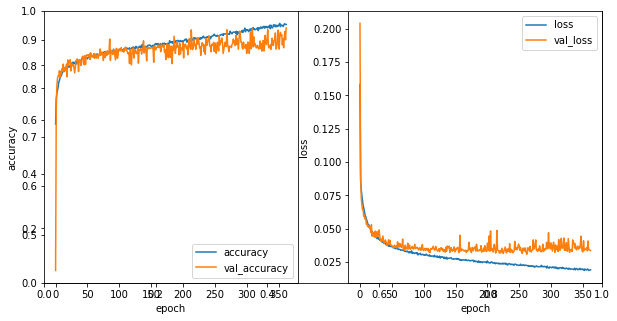

두 번째 시도 : 0.915986955165863 (earlystop 없음)

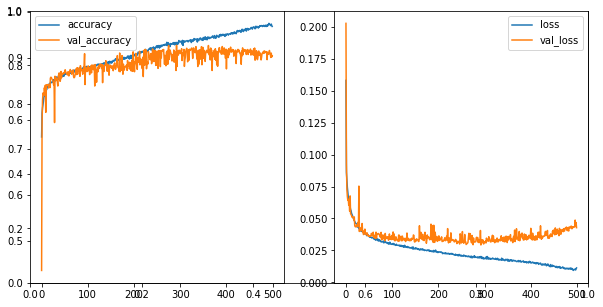


타입스텝 200으로 올렸을 때 결과 : 0.8690228462219238

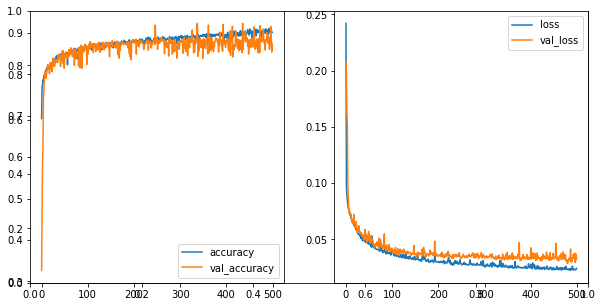



타입 스텝: 200, 스텝 : 200

커널 : 3개 / 32 64 128 128 64 32

classifier : CNN : 13 LSTM : 32

결과 : 0.8953568935394287

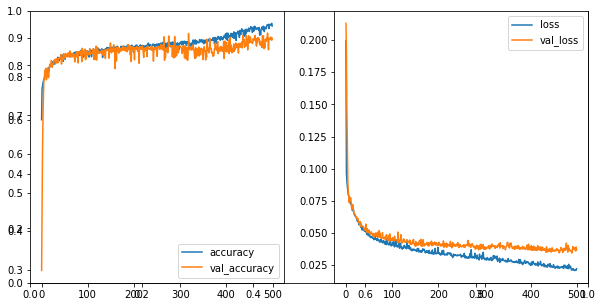